In [111]:
import pandas as pd
import copy
import math
import matplotlib.pyplot as plt
import os
import numpy as np
os.chdir('/Users/jericho/Documents/csi/csi-research')
import regress_k

In [31]:
# Import & Clean CBSA Crosswalk
cbsa_crosswalk_df = pd.read_csv('/Users/jericho/Documents/csi/csi-research/Data/cbsa-county-region-crosswalk.csv')
cbsa_crosswalk_df['FIPS State Code'] = cbsa_crosswalk_df['FIPS State Code'].astype(str).apply(lambda x: x.zfill(2))
cbsa_crosswalk_df['FIPS County Code'] = cbsa_crosswalk_df['FIPS County Code'].astype(str).apply(lambda x: x.zfill(3))
cbsa_crosswalk_df['FIPS'] = cbsa_crosswalk_df['FIPS State Code'] + cbsa_crosswalk_df['FIPS County Code']
cbsa_crosswalk_df = cbsa_crosswalk_df[['CBSA Code','FIPS']]

# Import & Clean CBSA Population Data
cbsa_data = pd.read_csv('/Users/jericho/Documents/csi/csi-research/Data/clean/cbsa/cbsa_summary.csv')
cbsa_data = cbsa_data[['GTCBSA','POP','LOG_POP']]
cbsa_data.columns = ['cbsa','pop','log_pop']
cbsa_data['cbsa'] = cbsa_data['cbsa'].astype(str).apply(lambda x: x.zfill(5))

In [3]:
def import_c19_data(s,fip,data):
    # Import data from JHU Git csv file & format FIPS codes
    df = pd.read_csv(s)
    cols = df.columns.tolist()
    cols = [cols[fip]] + cols[data:]
    df = df[cols]
    df = df[~df['FIPS'].isna()]
    df['FIPS'] = df['FIPS'].astype(int)
    df['FIPS'] = df['FIPS'].astype(str).apply(lambda x: x.zfill(5))
    return df

def aggregate_cbsa(data, cbsas):
    # Aggregate JHU C19 data to CBSAs using crosswalk
    df = data.merge(cbsas, on='FIPS', how='left')
    df = df[~df['CBSA Code'].isna()]
    df['CBSA Code'] = df['CBSA Code'].astype(int)
    df['CBSA Code'] = df['CBSA Code'].astype(str).apply(lambda x: x.zfill(5))
    df = df[['FIPS','CBSA Code'] + df.columns.tolist()[1:-1]]
    df = df.groupby(by='CBSA Code').sum()
    return df

In [70]:
def add_cbsa_index(df,cbsas):
    df['cbsa'] = cbsas
    df = df.set_index('cbsa')
    return df

def calc_ks(df):
    cbsas, slopes, intercepts, k_arrays = [],[],[],[]
    cols = df.columns.tolist()
    for cbsa, row in df.iterrows():
        array = row.tolist()
        s,i,ks = regress_k.generate_regressions(array,waves=True)
        cbsas.append(cbsa)
        slopes.append(s)
        intercepts.append(i)
        k_arrays.append(ks)
    slopes_df = add_cbsa_index(pd.DataFrame(slopes, columns = cols), cbsas)
    intercept_df = add_cbsa_index(pd.DataFrame(intercepts, columns = cols), cbsas)
    k_df = add_cbsa_index(pd.DataFrame(k_arrays, columns = ['wave1','wave2','wave3']), cbsas)
    return slopes_df, intercept_df, k_df

def bin_equal(array,bins):
    amin,amax = min(array),max(array)
    step = (amax-amin)/bins
    bins = [(i-amin)//step for i in array]
    mbin = max(bins)
    bin_partitions = [amin+step*i for i in range(int(mbin)+2)]
    return bins, bin_partitions

In [79]:
if 'cases_slope_df' not in locals():
    # Check locals to prevent accidentally re-running regressions
    c19_cases = import_c19_data('/Users/jericho/Documents/csi/csi-research/Data/time_series_covid19_confirmed_US.csv',4,11)
    c19_deaths = import_c19_data('/Users/jericho/Documents/csi/csi-research/Data/time_series_covid19_deaths_US.csv',4,12)
    cbsa_cases  = aggregate_cbsa(c19_cases,  cbsa_crosswalk_df)
    cbsa_deaths = aggregate_cbsa(c19_deaths, cbsa_crosswalk_df)
    cases_slope_df, cases_intercept_df, cases_k_df = calc_ks(cbsa_cases)
    death_slope_df, death_intercept_df, death_k_df = calc_ks(cbsa_deaths)
    cases_slope_df = cases_slope_df.reset_index()
    death_slope_df = death_slope_df.reset_index()
    cases_k_df = cases_k_df.reset_index()
    death_k_df = death_k_df.reset_index()

/Users/jericho/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


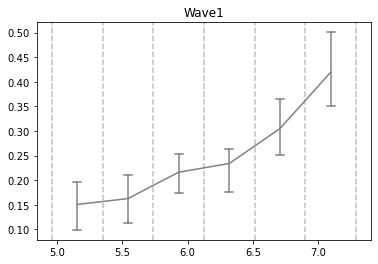

In [137]:
def find_iqr(bins, vals):
    bin_dict = {}
    for i in range(int(max(bins)+1)):
        bin_dict[i] = [vals[j] for j in range(len(vals)) if bins[j] == i]
    bin_iqr = {}
    for k,v in bin_dict.items():
        vals = [i for i in v if not np.isnan(i)]
        ys = sorted(vals)
        if len(vals) > 4:
            lq = ys[int(len(vals)*0.25)]
            uq = ys[int(len(vals)*0.75)]
            mu = sum(vals)/len(vals)
        else:
            lq = ys[0]
            uq = ys[-1]
            mu = sum(vals)/len(vals)
        bin_iqr[k] = [lq,mu,uq]
    return bin_iqr

def binplot(bins, vals, bin_p):
    bin_iqr = find_iqr(bins,vals)
    for v in bin_p:
        plt.axvline(x=v,linestyle='--',c='grey',alpha=0.5)
    xs = []
    ys = []
    for k,v in sorted(bin_iqr.items()):
        x = (bin_p[k]+bin_p[k+1])/2
        xs.append(x)
        ys.append(v[1])
        plt.plot([x,x],[v[0],v[-1]],c='grey')
        plt.plot([x-0.03,x+0.03], [v[0],v[0]],c='grey')
        plt.plot([x-0.03,x+0.03], [v[-1],v[-1]],c='grey')
    plt.plot(xs,ys,c='grey')

In [141]:
death_k_pop = copy.deepcopy(cbsa_data)
death_k_pop = death_k_pop.merge(death_k_df, on='cbsa', how='left')
pops = death_k_pop['log_pop'].tolist()
pop_bins,bin_partitions = bin_equal(pops,6)
death_k_pop['bin'] = pop_bins

death_slope_pop = copy.deepcopy(cbsa_data)
death_slope_pop = death_slope_pop.merge(death_slope_df, on='cbsa', how='left')
pops = death_slope_pop['log_pop'].tolist()
pop_bins,bin_partitions = bin_equal(pops,6)
death_slope_pop['bin'] = pop_bins

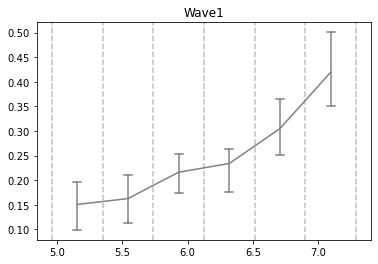

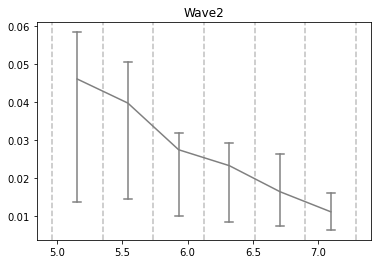

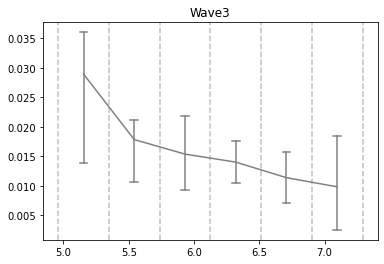

In [139]:
for i in range(1,4):
    binplot(death_k_pop['bin'],death_k_pop[f'wave{i}'],bin_partitions)
    plt.title(f'Wave{i}')
    plt.show()

In [142]:
death_slope_pop.columns

Index(['cbsa', 'pop', 'log_pop', '1/22/20', '1/23/20', '1/24/20', '1/25/20',
       '1/26/20', '1/27/20', '1/28/20',
       ...
       '6/19/21', '6/20/21', '6/21/21', '6/22/21', '6/23/21', '6/24/21',
       '6/25/21', '6/26/21', '6/27/21', 'bin'],
      dtype='object', length=527)

In [155]:
loc = '/Users/jericho/Documents/csi/csi-research/plots/slopes_t/'
for i in death_slope_pop.columns.tolist()[3:-1]:
    pass
    '''s = i.split('/')
    for j in range(len(s)):
        if len(s[j]) < 2:
            s[j] = '0'+s[j]
    date = '20'+s[2]+'-'+s[0]+'-'+s[1]
    plt.figure(figsize=(6,4))
    binplot(death_slope_pop['bin'],death_slope_pop[i],bin_partitions)
    plt.title(date)
    plt.ylabel('Slope')
    plt.xlabel('log-population')
    plt.savefig(loc+date)'''

In [158]:
window = 14

cols = death_slope_pop.columns.tolist()
dates = cols[3:-1]


['1/22/20',
 '1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/